In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
listings = glob.glob(os.path.join("data", "listings_*.csv"))
listings = pd.concat((pd.read_csv(f) for f in listings), ignore_index=True)

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191346 entries, 0 to 191345
Data columns (total 75 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            191346 non-null  int64  
 1   listing_url                                   191346 non-null  object 
 2   scrape_id                                     191346 non-null  int64  
 3   last_scraped                                  191346 non-null  object 
 4   source                                        191346 non-null  object 
 5   name                                          191346 non-null  object 
 6   description                                   182885 non-null  object 
 7   neighborhood_overview                         97536 non-null   object 
 8   picture_url                                   191342 non-null  object 
 9   host_id                                       19

In [4]:
columns_to_drop = [
    # "id", # jointure avec calendar
    "listing_url",
    "scrape_id",
    "last_scraped",
    "source",
    "name",
    "description",
    "neighborhood_overview",
    "picture_url",
    "host_id",
    "host_url",
    "host_name",
    "host_since",
    "host_location",
    "host_about",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost", # peut être transformer en booléen et utiliser
    "host_thumbnail_url",
    "host_picture_url",
    "host_neighbourhood",
    "host_listings_count",
    "host_total_listings_count", # utiliser avec superhost
    "host_verifications",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood",
    # "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "latitude",
    "longitude",
    "property_type",
    # "room_type",
    # "accommodates",
    "bathrooms",
    # "bathrooms_text",
    # "bedrooms",
    # "beds",
    # "amenities",
    # "price",
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm", # peut être utile car + longue période = moins cher
    "maximum_nights_avg_ntm", # peut être utile car + longue période = moins cher
    "calendar_updated",
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    # "availability_365",
    "calendar_last_scraped",
    # "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "first_review",
    "last_review",
    # "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "license",
    "instant_bookable",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "reviews_per_month"
]

In [5]:
listings = listings.drop(columns=columns_to_drop)

In [6]:
def drop_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    duplicated = df.duplicated().sum()
    if duplicated > 0:
        print(f"{duplicated} duplicated rows")
        df = df.drop_duplicates()
    return df

In [7]:
listings = drop_duplicates(listings)

230 duplicated rows


In [8]:
listings.head(5)

,id,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_rating
0,80260,Ménilmontant,Entire home/apt,3,1 bath,1.0,NaN,"[""Hangers"", ""Essentials"", ""Wifi"", ""Dishes and ...",NaN,0,206,4.63
1,3109,Observatoire,Entire home/apt,2,1 bath,1.0,0.0,"[""Smart lock"", ""Smoke alarm"", ""Cooking basics""...",$250.00,349,4,5.00
2,80301,Panthéon,Private room,1,1.5 baths,1.0,1.0,"[""Stove"", ""Host greets you"", ""Extra pillows an...",$60.00,145,42,4.83
3,5396,Hôtel-de-Ville,Entire home/apt,2,1 bath,0.0,1.0,"[""Stove"", ""Host greets you"", ""Extra pillows an...",$96.00,154,403,4.61
4,7397,Hôtel-de-Ville,Entire home/apt,4,1 bath,2.0,1.0,"[""Stove"", ""Host greets you"", ""Extra pillows an...",$160.00,277,354,4.73


In [9]:
def get_column_missing_value_percentage(df: pd.DataFrame) -> pd.Series:
    missing_values = df.isnull().mean() * 100
    missing_values = missing_values[missing_values > 0]
    return missing_values.sort_values(ascending=False)

In [10]:
def show_missing_column_values(df: pd.DataFrame) -> None:
    missing_values = get_column_missing_value_percentage(df)
    ax = missing_values.plot.bar()
    ax.set_ylabel("Pourcentage de valeurs manquantes")
    ax.set_xlabel("Colonnes")
    ax.set_title("Pourcentage de valeurs manquantes par colonnes")
    plt.show()

In [11]:
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '')
    return x

In [12]:
# Traitement des colonnes
listings['price'] = listings['price'].astype(str).apply(clean_currency).fillna(0).astype(float)
listings['beds'] = listings['beds'].fillna(0).astype(int)
listings['bedrooms'] = listings['bedrooms'].fillna(0).astype(float)
listings['accommodates'] = listings['accommodates'].fillna(0).astype(int)
listings['bathrooms_text'] = listings['bathrooms_text'].str.extract(r'(\d+)').astype(float)
listings['amenities'] = listings['amenities'].apply(lambda x: len(x.split(','))).astype(int)
listings.rename(columns={"bathrooms_text": "bathrooms", "neighbourhood_cleansed": "neighbourhood"}, inplace=True)

In [13]:
listings.head(5)

,id,neighbourhood,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_rating
0,80260,Ménilmontant,Entire home/apt,3,1.0,1.0,0,10,NaN,0,206,4.63
1,3109,Observatoire,Entire home/apt,2,1.0,1.0,0,15,250.0,349,4,5.00
2,80301,Panthéon,Private room,1,1.0,1.0,1,30,60.0,145,42,4.83
3,5396,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1,38,96.0,154,403,4.61
4,7397,Hôtel-de-Ville,Entire home/apt,4,1.0,2.0,1,25,160.0,277,354,4.73


In [14]:
get_column_missing_value_percentage(listings)

review_scores_rating    30.959208
price                   27.389125
bathrooms                0.610624
dtype: float64

## Remplissage des reviews vides

In [15]:
# traitement des reviews manquants
# reviews = glob.glob(os.path.join("data", "reviews_*.csv"))
# reviews = pd.concat((pd.read_csv(f) for f in reviews), ignore_index=True)

In [16]:
# reviews.head(5)

In [17]:
# reviews = drop_duplicates(reviews)

In [18]:
# Bert Model has 512 max tokens limit
# MAX_TOKENS = 512
# comments = reviews['comments'].astype(str).tolist()
# comments = [comment[:MAX_TOKENS] for comment in comments]

In [19]:
# from transformers import pipeline
# MODEL="nlptown/bert-base-multilingual-uncased-sentiment"
# pipe = pipeline("text-classification", model=MODEL)

In [20]:
# sentiments = pipe(comments)
# la tâche devrait prendre environ 4 heures (7 secondes par 100 commentaires)

In [21]:
# reviews = reviews[["listing_id", "comments"]]
# reviews['sentiment'] = [sentiment['label'] for sentiment in sentiments]

# TODO extraire la note de la colonne sentiment

## Remplissage des prix vides

In [22]:
calendars = glob.glob(os.path.join("data", "calendar_*.csv"))
calendars = pd.concat((pd.read_csv(f) for f in calendars), ignore_index=True)

C:\Users\msatf\AppData\Local\Temp\ipykernel_7420\2527921994.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendars = pd.concat((pd.read_csv(f) for f in calendars), ignore_index=True)
C:\Users\msatf\AppData\Local\Temp\ipykernel_7420\2527921994.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendars = pd.concat((pd.read_csv(f) for f in calendars), ignore_index=True)


In [23]:
calendars.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2024-06-12,f,$250.00,NaN,2.0,30.0
1,3109,2024-06-13,t,$250.00,NaN,2.0,30.0
2,3109,2024-06-14,t,$250.00,NaN,2.0,30.0
3,3109,2024-06-15,t,$250.00,NaN,2.0,30.0
4,3109,2024-06-16,t,$250.00,NaN,2.0,30.0


In [24]:
calendars = calendars[['listing_id', 'price']]
calendars['price'] = calendars['price'].apply(clean_currency).astype(float)

In [25]:
# calcul de la médiane des prix par annonce
calendars = calendars.groupby('listing_id').median()
calendars = calendars.reset_index()

price_mapping = calendars.set_index('listing_id')['price'].to_dict()

# release memory
del calendars

In [26]:
# assignation des prix manquants
listings['price'] = listings['price'].fillna(listings['id'].map(price_mapping))

In [27]:
get_column_missing_value_percentage(listings)

review_scores_rating    30.959208
bathrooms                0.610624
dtype: float64

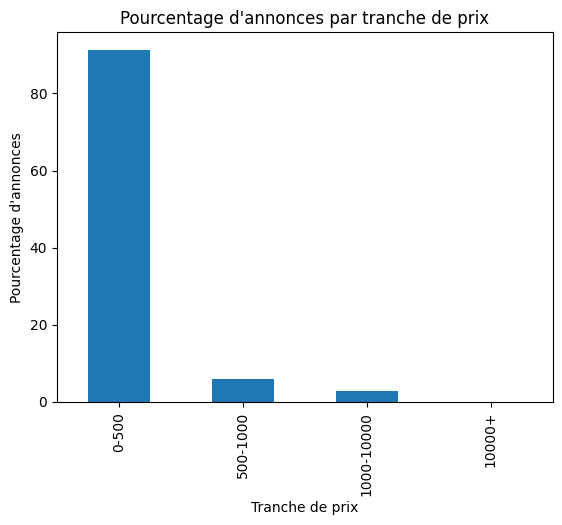

In [28]:
# Définir les tranches de prix
bins = [0, 500, 1000, 10000, listings['price'].max()]
labels = ['0-500', '500-1000', '1000-10000', '10000+']

# Créer une nouvelle colonne 'price_range' dans le dataframe
listings['price_range'] = pd.cut(listings['price'], bins=bins, labels=labels, right=False)

# Calculer le pourcentage d'annonces par tranche de prix
price_range_percentage = listings['price_range'].value_counts(normalize=True) * 100

# Tracer le graphique
ax = price_range_percentage.plot(kind='bar')
ax.set_ylabel("Pourcentage d'annonces")
ax.set_xlabel("Tranche de prix")
ax.set_title("Pourcentage d'annonces par tranche de prix")
plt.show()

In [29]:
# La plupart des données sont situées en dessous de 500€, on peut donc supprimer les annonces au dessus 
listings = listings[listings['price'] <= 500]

# on supprime la colonne price_range car elle n'est plus utile
listings = listings.drop(columns=['price_range'])

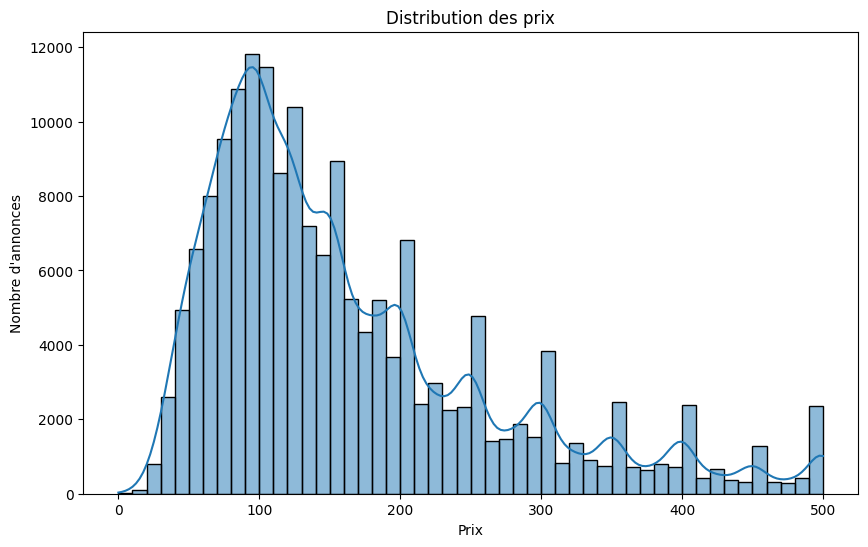

In [30]:
# Distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(listings['price'], bins=50, kde=True)
plt.title("Distribution des prix")
plt.xlabel("Prix")
plt.ylabel("Nombre d'annonces")
plt.show()

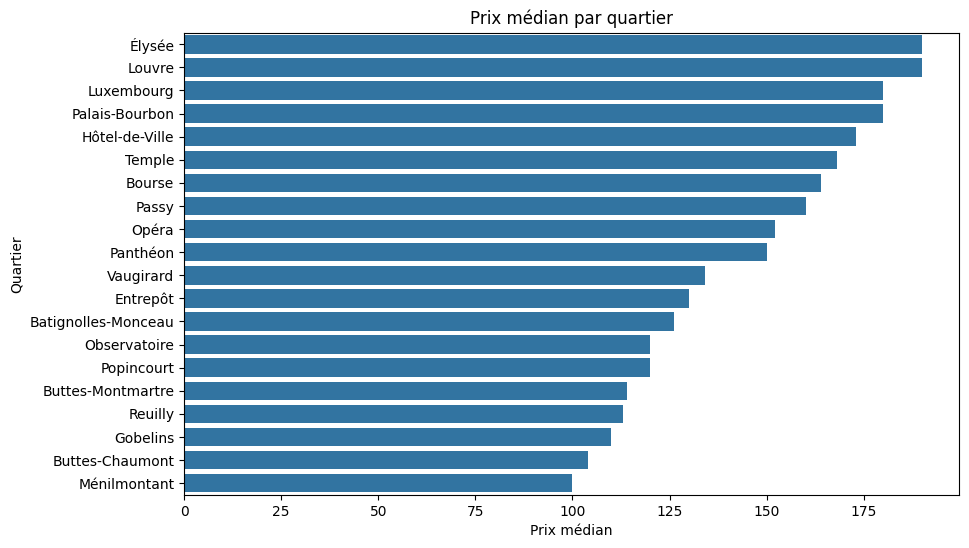

In [32]:
plt.figure(figsize=(10, 6))
median_prices = listings.groupby('neighbourhood')['price'].median().sort_values(ascending=False)
sns.barplot(x=median_prices.values, y=median_prices.index)
plt.title("Prix médian par quartier")
plt.xlabel("Prix médian")
plt.ylabel("Quartier")
plt.show()

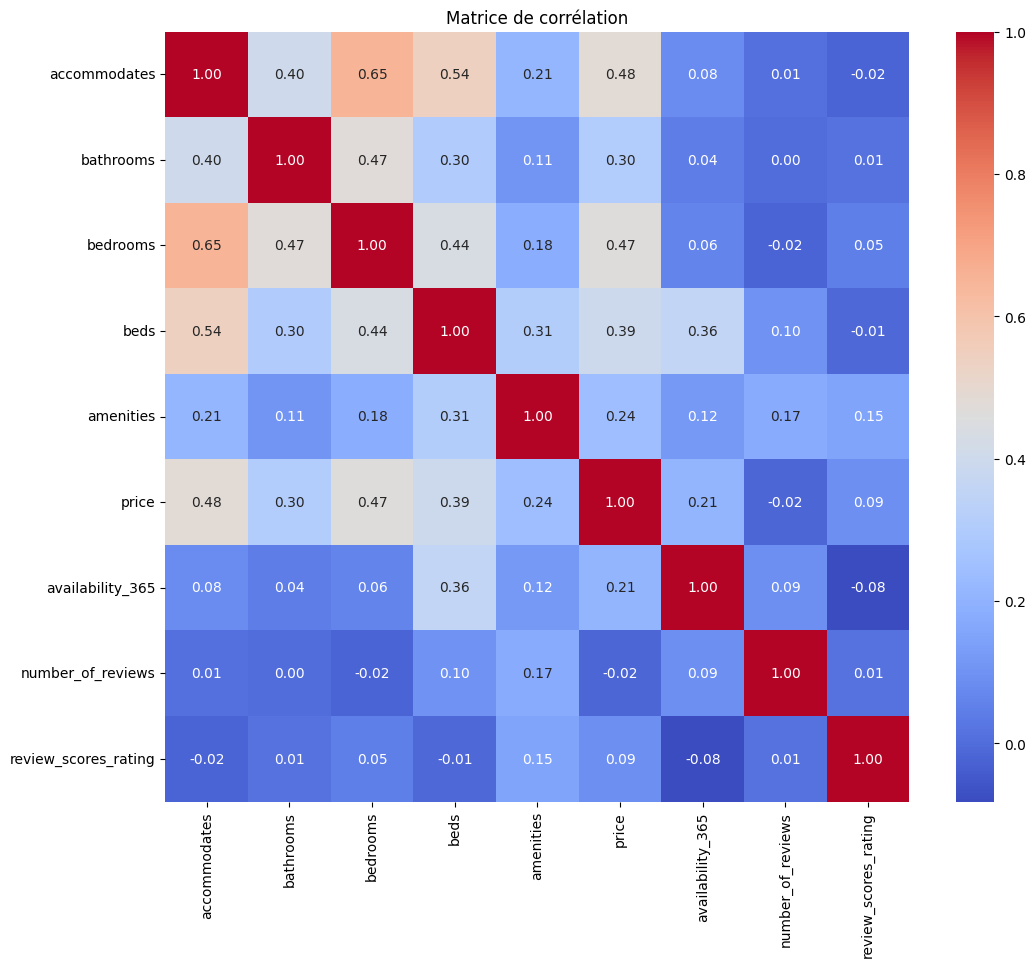

In [33]:
# matrice de corrélation
plt.figure(figsize=(12, 10))
corr = listings.select_dtypes(include=[np.number]).drop(columns=['id']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

In [34]:
# les colonnes 'number_of_reviews' et 'review_scores_rating' ne semblent pas être corrélées avec le prix
# on peut donc les supprimer
listings = listings.drop(columns=['number_of_reviews', 'review_scores_rating'])

In [35]:
# export to csv
listings.to_csv("data/clean_listings.csv", index=False)